# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Information sources used for this project
The following resources were consulted during preparation of this project:

- The [c231n web site](http://cs231n.stanford.edu/syllabus.html) and lecture videos

- This [paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) by Yann LeCun

- Udacity's Slack forum and Confluence web site

- Hvass laboratories' [Youtube videos](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

- The nanodegree lectures

- Stackoverflow

### Preparation

#### Imports

In [1]:
import tensorflow as tf                                 # v0.12.0-rc0
import numpy as np                                      # v1.11.2
import matplotlib.pyplot as plt                         # v1.5.3
import seaborn as sns                                   # v0.7.1
import cv2                                              # v3.1.0
from sklearn.preprocessing import LabelBinarizer        # v1.18.1
from sklearn.model_selection import train_test_split
import time, os, pickle                                 # v3.5.2
from math import ceil
%matplotlib inline

#### Constants

In [2]:
# Image details
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
NUM_CHANNELS = 3            # 1 = grayscale/YUV (Y channel only), 3 = RGB
NEW_IMAGE_NUM_CHANNELS = 3  # Test images from the internet are always RGB
CONVERT_TO_YUV = False      # True = convert to YUV,only keep the Y channel, False = no conversion
Y_CHANNEL = 0               # Column holding the Y channel

# Training parameters
EPOCHS = 25                 # Number of epochs
BATCH_SIZE = 256            # Reduce this depending on amount of RAM available
MODEL_SELECTION = 1         # 0 = use LeNet model, 1 = use AlexNet model
TRAIN_VAL_SPLIT = 0.1       # Use 10% of the training dataset as the validation dataset
DROPOUT_KEEP_PROB = 0.5
LEARNING_RATE = 0.001       # Initial learning rate
DECAY_EVERY = 5             # Number of epochs the learning rate will be decayed
DECAY_RATE = 0.96           # Learning rate decay rate

# Paths
MODEL_SAVE_PATH = "./models"                        # Filename of the TensorFlow model
NEW_IMAGES_PATH = "./new-images"                    # Path were captured images are stored

# Number of predictions to show for each image found on the internet
TOP_PREDICTIONS = 5

# Set numpy array printing options
np.set_printoptions(precision=8, suppress=True)

> **Note**: This workbook was executed on an early 2016 2.5GHz MBP with 16GB of RAM. The BATCH_SIZE constant declared above may need to be changed for machines with more/less memory.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

#### Load data

In [3]:
# Load pickled training and test datasets
training_file = './lab 2 data/train.p'
testing_file = './lab 2 data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

#### Basic data summary

In [4]:
# Number of training and test examples
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# Image shape
image_shape = train['features'].shape[1:]

# Number of classes in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print(" Number of testing examples =", n_test)
print("           Image data shape =", image_shape)
print("          Number of classes =", n_classes)

Number of training examples = 39209
 Number of testing examples = 12630
           Image data shape = (32, 32, 3)
          Number of classes = 43


#### Data exploration visualization

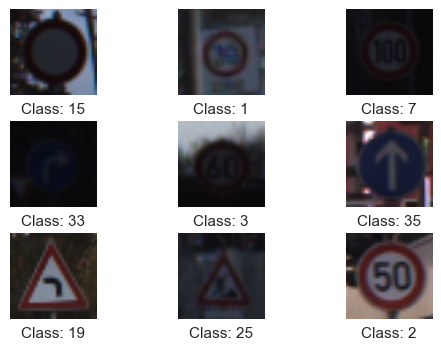

In [5]:
def plot_images(images, label_true, label_pred=None):
    '''Plot images, their true labels and the predicted label (if available). Note this function
    is hardcoded to always display exactly 9 images'''
    fig, ax = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(ax.flat):
        if NUM_CHANNELS==1:
            ax.imshow(images[i].squeeze(), cmap='gray')
        else:
            ax.imshow(images[i])
        
        if label_pred is None:
            lbl = "Class: {}".format(label_true[i])
        else:
            lbl = "Class: {}, Prediction: {}".format(label_true[i], label_pred[i])
            
        ax.set_xlabel(lbl)
        ax.set_xticks([])
        ax.set_yticks([])

# Select nine random training images and plot them
img_idx = np.random.randint(low=0, high=n_train, size=3*3)
plot_images(X_train[img_idx], y_train[img_idx])

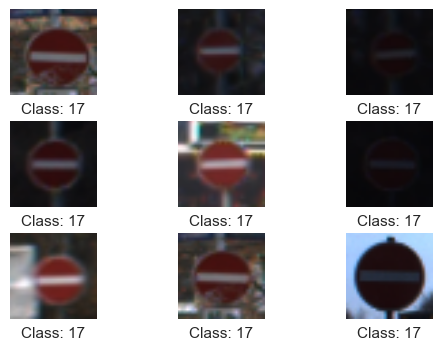

In [6]:
def plot_class(images, images_classes, class_num):
    '''Plots 9 random images of a particular class. This function was used during model
    development but is now no longer used'''
    class_idxs = np.argwhere(images_classes == class_num).flatten()
    img_idx = np.random.randint(low=0, high=len(class_idxs), size=3*3)
    
    plot_images(images[class_idxs[img_idx]], images_classes[class_idxs[img_idx]])

# Plot nine random images of a particular class
plot_class(X_train, y_train, 17)

#### Determine the number of images per class

(0, 2500)

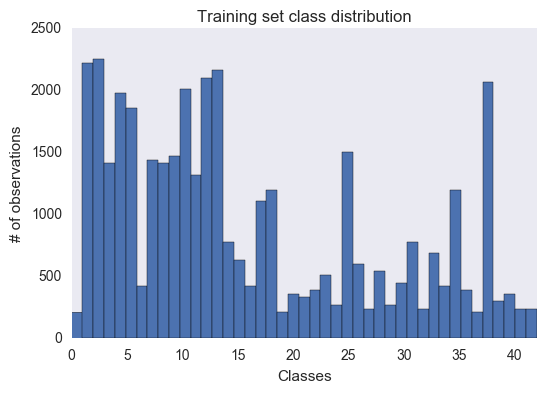

In [7]:
# Show a histogram of class labels
fig = plt.figure()                                                               
ax = fig.add_subplot(1,1,1)
plt.yticks(np.arange(0, 2501, 500))
plt.hist(y_train, bins=43)
plt.xlabel('Classes')
plt.ylabel('# of observations')
plt.title('Training set class distribution')
plt.grid()
plt.xlim([0, n_classes-1])
plt.ylim([0, 2500])

#### Findings

1. The number of training images available for each class varies wildy

2. Some of the image are extremely dark

3. Images are grouped by class label

4. Image classes 41 and 42 are very similar (I found them hard to distinguish manually) 

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Preprocessing helper functions

In [8]:
def normalize_image(image_data):
    '''Normalize image color channels to be between 0.1 and 0.9'''
    a = 0.1
    b = 0.9
    min_val = 0
    max_val = 255
    return a + (((image_data - min_val) * (b - a)) / (max_val - min_val))

In [9]:
def convert_to_grayscale(dataset):
    '''Convert images to grayscale'''
    X_tmp = np.zeros([dataset.shape[0], dataset.shape[1], dataset.shape[2]]).astype('uint8')

    for i in range(len(dataset)):
        X_tmp[i,] = cv2.cvtColor(dataset[i,], cv2.COLOR_RGB2GRAY)

    return X_tmp.reshape(-1, 32, 32, NUM_CHANNELS)

In [10]:
def convert_to_YUV(dataset):
    '''Convert to YUV and only return the Y channel'''
    X_tmp = np.zeros([dataset.shape[0], dataset.shape[1], dataset.shape[2]]).astype('uint8')

    for i in range(len(dataset)):
        X_tmp[i,] = cv2.cvtColor(dataset[i,], cv2.COLOR_RGB2YUV)[:,:,Y_CHANNEL]

    return X_tmp.reshape(-1, 32, 32, NUM_CHANNELS)

### Preprocess the data here

In [11]:
def preprocess_images(images):
    '''Applies preprocessing to a dataset'''
    if (NUM_CHANNELS == 1) and (CONVERT_TO_YUV == False):
        print('Converted to grayscale')
        tmp_images = convert_to_grayscale(images)
    elif (NUM_CHANNELS == 1) and (CONVERT_TO_YUV == True):
        print('Converted to YUV')
        tmp_images = convert_to_YUV(images)
    else:
        tmp_images = images
        print('No color conversion performed')

    print('Min/max normalization performed')
    return normalize_image(tmp_images)

In [12]:
# One-hot-encode the labels (both the training and test set)
lb = LabelBinarizer()
y_train_onehot = lb.fit_transform(y_train)
y_test_onehot = lb.transform(y_test)

No color conversion performed
Min/max normalization performed
No color conversion performed
Min/max normalization performed


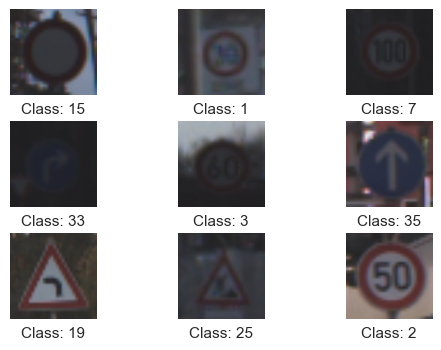

In [13]:
# Preprocess the two datasets
X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

# Show the same images shown earlier, after preprocessing
plot_images(X_train[img_idx], y_train[img_idx])
del img_idx

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** The following preprocessing steps are performed:

1. class labels are one-hot encoded
2. images are min/max normalized (inspired by the nanodegree lectures), this will ensure features are all on the same scale, and help with converging to optimum weights faster

Only at the last minute was the conversion to YUV color space, and taking only the Y channel (inspired by Yann LeCun's paper), dropped. The idea was that this conversion enhances the very dark/low contrast of some images somewhat. It was dropped to see whether keeping RGB colors would perform better. Surprisingly, it did.

### Split the data into training/validation/testing sets here

In [14]:
# Split the training set into a training and validation set
X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(X_train,
                                                                y_train_onehot,
                                                                test_size=TRAIN_VAL_SPLIT,
                                                                stratify=y_train,
                                                                random_state=0)

n_train = len(X_train)
n_val = len(X_val)
n_test = len(X_test)

print("  Number of training examples =", n_train)
print("Number of validation examples =", n_val)
print("   Number of testing examples =", n_test)

  Number of training examples = 35288
Number of validation examples = 3921
   Number of testing examples = 12630


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** additional images created by perturbing the images in the training set may help prevent overfitting and improve model performance. It may also be used to address the current imbalance between the number of images available in each image class. However, time constraints prevented implementation of this. Adding images by perturbing the existing ones is probably the first thing I would do next.

The training set is split into a 10% validation set and 90% training set using sci-kit learn's `train_test_split` function. This function ensures images are split **randomly** between the two sets. The `stratify` parameter ensures that image classes are **evenly distributed** over both sets.

### Define your architecture here

In [15]:
# Avoid save/restore problems caused by executing cells creating TensorFlow variables multiple
# times. After executing this cell,  any cells creating TensforFlow variables should only be
# executed once.
tf.reset_default_graph()

#### Layer definitions: AlexNet (adaptation of)

In [16]:
# Layer widths/depths
alex_layer_width = {
    'layer_1': 96,
    'layer_2': 256,
    'layer_3': 384,
    'fully_connected1': 4096,
    'fully_connected2': 4096,
}

# Layer weights
alex_weights = {
    'layer_1': tf.Variable(tf.truncated_normal([4, 4, NUM_CHANNELS, alex_layer_width['layer_1']], stddev=0.05)),
    'layer_2': tf.Variable(tf.truncated_normal([4, 4, alex_layer_width['layer_1'], alex_layer_width['layer_2']], stddev=0.05)),
    'layer_3': tf.Variable(tf.truncated_normal([2, 2, alex_layer_width['layer_2'], alex_layer_width['layer_3']], stddev=0.05)),
    'fully_connected1': tf.Variable(tf.truncated_normal([4 * 4 * 384, alex_layer_width['fully_connected1']], stddev=0.05)),
    'fully_connected2': tf.Variable(tf.truncated_normal([alex_layer_width['fully_connected1'], alex_layer_width['fully_connected2']], stddev=0.05)),
    'out': tf.Variable(tf.truncated_normal([alex_layer_width['fully_connected2'], n_classes], stddev=0.05))
}

# Layer biases
alex_biases = {
    'layer_1': tf.Variable(  tf.constant(0.05, shape=[alex_layer_width['layer_1']])  ),
    'layer_2': tf.Variable(tf.constant(0.05, shape=[alex_layer_width['layer_2']])),
    'layer_3': tf.Variable(tf.constant(0.05, shape=[alex_layer_width['layer_3']])),
    'fully_connected1': tf.Variable(tf.constant(0.05, shape=[alex_layer_width['fully_connected1']])),
    'fully_connected2': tf.Variable(tf.constant(0.05, shape=[alex_layer_width['fully_connected2']])),
    'out': tf.Variable(tf.constant(0.05, shape=[n_classes]))
}

#### Layer definitions: LeNet (not used in the final model)
Do not execute the cell below otherwise the restore will not work.

In [ ]:
le_layer_width = {
    'layer_1': 6,
    'layer_2': 16,
    'fully_connected1': 1024,
}

le_weights = {
    'layer_1': tf.Variable(tf.truncated_normal([5, 5, NUM_CHANNELS, le_layer_width['layer_1']], stddev=0.05)),
    'layer_2': tf.Variable(tf.truncated_normal([5, 5, le_layer_width['layer_1'], le_layer_width['layer_2']], stddev=0.05)),
    'fully_connected1': tf.Variable(tf.truncated_normal([5 * 5 * 16, le_layer_width['fully_connected1']], stddev=0.05)),
    'out': tf.Variable(tf.truncated_normal([le_layer_width['fully_connected1'], n_classes], stddev=0.05))
}

le_biases = {
    'layer_1': tf.Variable(tf.constant(0.05, shape=[le_layer_width['layer_1']])),
    'layer_2': tf.Variable(tf.constant(0.05, shape=[le_layer_width['layer_2']])),
    'fully_connected1': tf.Variable(tf.constant(0.05, shape=[le_layer_width['fully_connected1']])),
    'out': tf.Variable(tf.constant(0.05, shape=[n_classes]))
}

#### Architecture helper functions

In [17]:
def conv2d(x, W, b, strides=1, pad='VALID'):
    '''Create a convolution layer'''
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=pad)
    x = tf.nn.bias_add(x, b)
    return x


def maxpool2d(x, f, k, pad):
    '''Create a MaxPool layer'''
    return tf.nn.max_pool(x,
                          ksize=[1, f, f, 1],
                          strides=[1, k, k, 1],
                          padding=pad)


def eval_data(data_x, data_y, batch_size):
    """Calculate the loss and accuracy for two datasets, dividing them into batches"""
    total_acc, total_loss, total_obs = 0, 0, 0

    # Calculate the mean loss and accuracy for each batch, keep a tally of the total (i.e not
    # the mean) of the loss and accuracy
    for (k, batch_x, batch_y) in batches(data_x, data_y, batch_size):
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
        total_obs += len(batch_x)

    # Return the mean loss and accuracy
    return total_loss/total_obs, total_acc/total_obs


def batches(X, y, batch_size):
    '''Returns a generator that splits the two datasets into batches'''
    n = int(ceil(len(X) / batch_size))
    for k in range(n):
        a = k * batch_size
        b = a + batch_size
        yield (k, X[a:b], y[a:b])

#### Build the network: AlexNet

In [18]:
def build_alexnet_drop(x):
    '''Returns the logits for each class for input x using an AlexNet inspired ConvNet'''

    # Layer 1
    conv1 = conv2d(x, alex_weights['layer_1'], alex_biases['layer_1'], strides=2, pad='SAME')
    conv1 = tf.nn.relu(conv1)

    # Layer 2
    conv2 = conv2d(conv1, alex_weights['layer_2'], alex_biases['layer_2'], strides=2, pad='SAME')
    conv2 = tf.nn.relu(conv2)

    # Layer 3
    conv3 = conv2d(conv2, alex_weights['layer_3'], alex_biases['layer_3'], strides=2, pad='VALID')
    conv3 = tf.nn.relu(conv3)
    
    # Flatten layer
    flat = tf.contrib.layers.flatten(conv3)
    
    # Fully connected 1
    fc1 = tf.reshape(flat, [-1, alex_weights['fully_connected1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, alex_weights['fully_connected1']), alex_biases['fully_connected1'])
    fc1 = tf.nn.relu(fc1)
    
    # Fully connected 2
    fc2 = tf.reshape(fc1, [-1, alex_weights['fully_connected2'].get_shape().as_list()[0]])
    fc2 = tf.add(tf.matmul(fc2, alex_weights['fully_connected2']), alex_biases['fully_connected2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Fully connected 3 - 43 outputs
    logits = tf.add(tf.matmul(fc2, alex_weights['out']), alex_biases['out'])

    # Return the logits (i.e. these are not probabilities)
    return logits

#### Build the network: LeNet (not used in the final model)
Do not execute the cell below otherwise the restore will not work.

In [ ]:
def build_lenet(x):
    '''Returns the logits for each class for input x using a LeNet inspired ConvNet'''

    # Layer 1 - 32*32*NUM_CHANNELS to 28*28*6
    conv1 = conv2d(x, le_weights['layer_1'], le_biases['layer_1'], strides=1)
    conv1 = tf.nn.relu(conv1)
    conv1 = maxpool2d(conv1, f=2, k=2, pad='VALID') # to 14x14x6

    # Layer 2 - 14x14x6 to 10x10x16
    conv2 = conv2d(conv1, le_weights['layer_2'], le_biases['layer_2'], strides=1)
    conv2 = tf.nn.relu(conv2)
    conv2 = maxpool2d(conv2, f=2, k=2, pad='VALID') # to 5x5x16

    # Flatten layer
    flat = tf.contrib.layers.flatten(conv2)

    # Fully connected 1 - 1024 outputs
    fc1 = tf.reshape(flat, [-1, le_weights['fully_connected1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, le_weights['fully_connected1']), le_biases['fully_connected1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Fully connected 2 - 43 outputs
    logits = tf.add(tf.matmul(fc1, le_weights['out']), le_biases['out'])

    # Return the result of the last fully connected layer.
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** the final model is a Convolutional Neural Network (CNN), more specifically a simplified version of AlexNet. It comprises the following layers: 

- Convolutional layer with a 4x4 filter, ReLu activation and 96 feature maps

- Convolutional layer with a 4x4 filter, ReLu activation and 256 feature maps

- Convolutional layer with a 2x2 filter, ReLu activation and 384 feature maps

- Fully connected layer with 4096 neurons

- Fully connected layer with 4096 neurons with 50% Dropout

- Final layer with 43 neurons

Pooling was not used because information sources, particularly the [CS231n web site](http://cs231n.stanford.edu) suggest pooling has fallen out of favour in recent times, with Dropout becoming more popular.

Before settling on the simplified AlexNet architecture the LeNet architecture was used. Even though the performance was not too bad, a more sophisticated model was required. More sophisticated models were considered, such as Inception and the ones discussed in [this paper](https://arxiv.org/pdf/1606.02228v2.pdf). However, time constraints and limits on available hardware meant these were not pursued further.

After settling on the model, hyperparameters were tuned.


### Train your model here

#### Training helper functions

In [19]:
def save_model(sess, epoch):
    '''Save TensorFlow model variables to disk, the current epoch becomes part of the name'''
    saver = tf.train.Saver()
    save_path = saver.save(sess, MODEL_SAVE_PATH + '/P2-epoch' + str(epoch) + '.ckpt')
    print("Model saved in file: %s" % save_path)

In [20]:
def load_model(sess, epoch=EPOCHS):
    '''Load previously saved TensorFlow model variables of a particular epoch'''
    saver = tf.train.Saver()
    saver.restore(sess, MODEL_SAVE_PATH + '/P2-epoch' + str(epoch) + '.ckpt')

In [21]:
def print_model_info():
    if MODEL_SELECTION==0:
        print('           Model: LeNet')
    else:
        print('           Model: AlexNet')
    
    if (NUM_CHANNELS == 1) and (CONVERT_TO_YUV == False):
        print('Color conversion: to grayscale')
    elif (NUM_CHANNELS == 1) and (CONVERT_TO_YUV == True):
        print('Color conversion: YUV (Y channel only)')
    else:
        print('Color conversion: none')    

    print('      Max epochs: {}'.format(EPOCHS))
    print('      Initial lr: {}'.format(LEARNING_RATE))
    print('      Batch size: {}'.format(BATCH_SIZE))
    print('   Lr Decay rate: {} every {} epochs'.format(DECAY_RATE, DECAY_EVERY))
    print('         Dropout: {}'.format(DROPOUT_KEEP_PROB))
    print(' # batches/epoch: {:.0f}'.format(n_train/BATCH_SIZE))
    print(' Train/val split: {}'.format(TRAIN_VAL_SPLIT))
    print('      Model path: {}\n'.format(MODEL_SAVE_PATH))

#### Prepare the TensorFlow graph

In [22]:
# Placeholders: x, y and the DropOut keep probability
x = tf.placeholder(tf.float32, (None, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
y = tf.placeholder(tf.float32, (None, n_classes))
keep_prob = tf.placeholder(tf.float32)

# Create the ConvNet
with tf.name_scope('Model') as scope:
    # Build the ConvNet (N x n_classes)
    if MODEL_SELECTION == 0:
        logits = build_lenet(x)
    else:
        logits = build_alexnet_drop(x)

# Loss function: mean cross-entropy 
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))

# Decay the learning rate every DECAY_EVERY epochs
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(LEARNING_RATE, global_step, n_train/BATCH_SIZE*DECAY_EVERY, DECAY_RATE, staircase=True)

# Optimizer: AdamOptimizer with default parameters
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss_op, global_step=global_step)

# Boolean vector indicating whether the prediction matches the actual label
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))

# Calculate the mean classification accuracy
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### Train the network

> **Note:** to restore a saved model and use it to make predictions on new images instead of training a new model simply skip the cell below

In [23]:
# Print model information
print_model_info()

# Start training
with tf.Session() as sess:
    
    # Keep track of processing time
    total_time = 0

    sess.run(tf.global_variables_initializer())
    
    for i in range(EPOCHS):
        start_time = time.time()

        lr = sess.run([learning_rate])
        print('EPOCH {:>3d}, lr = {:7.6f} - '.format(i+1, lr[0]), end='')

        # Iterate through the training data
        for (k, batch_x, batch_y) in batches(X_train, y_train_onehot, BATCH_SIZE):
            _, loss = sess.run([train_op, loss_op], feed_dict={x: batch_x, y: batch_y, keep_prob:DROPOUT_KEEP_PROB})

            if(k%25==0):
                print('{} '.format(k), end='')

        # Evaluate the model on the validation set
        val_loss, val_acc = eval_data(X_val, y_val_onehot, BATCH_SIZE)
        tf.summary.scalar('validation_loss', val_loss)
        tf.summary.scalar('validation_accuracy', val_acc)
        
        print('\nValidation set loss = {:<6.3f}, '.format(val_loss), end='')
        print('accuracy = {:<6.3f}'.format(val_acc), end='')

        # Save the trained model after each epoch
        save_model(sess, i)
        
        total_time += time.time() - start_time
        print('elapsed time = {:<.2f} min.\n'.format((time.time() - start_time)/60))

    # Evaluate on the entire test data
    print('Test set performance:')

    start_time = time.time()
    test_loss, test_acc = eval_data(X_test, y_test_onehot, BATCH_SIZE)
    print('          Test loss = {:<6.3f}'.format(test_loss))
    print('      Test accuracy = {:<6.3f}'.format(test_acc))
    total_time += time.time() - start_time
    print('         Total time = {:<.2f} min'.format(total_time/60.0))

           Model: AlexNet
Color conversion: none
      Max epochs: 2
      Initial lr: 0.001
      Batch size: 256
   Lr Decay rate: 0.96 every 5 epochs
         Dropout: 0.5
 # batches/epoch: 138
 Train/val split: 0.1
      Model path: ./models

EPOCH   1, lr = 0.001000 - 0 25 50 75 100 125 
Validation set loss = 0.270 , accuracy = 0.928 Model saved in file: ./models/P2-epoch0.ckpt
elapsed time = 3.79 min.

EPOCH   2, lr = 0.001000 - 0 25 50 75 100 125 
Validation set loss = 0.129 , accuracy = 0.970 Model saved in file: ./models/P2-epoch1.ckpt
elapsed time = 4.00 min.

Test set performance:
          Test loss = 0.434 
      Test accuracy = 0.890 
         Total time = 8.22 min


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** The AdamOptimizer was picked because it is more effective than Gradient Descent. It also seems a popular choice among the various information sources consulted for this project.


In terms of hyperparameters:

1. The number of epochs was simply determined by picking a number of epochs that balances finding an acceptable loss and accuracy with execution time. AWS is yet to enable g2.2xlarge instances for me so I had to rely on training models overnight

2. The batch size was initially set to 64. It was gradually increased to 256. Because my machine has 16Gb of RAM it can probably be increased further

3. The learning rate was initially fixed. I noticed that for later epochs the loss and accuracy did not increase and occassionally would even decrease slightly. This triggered me to implement learning rate decay, decreasing the learning rate exponentially after every five epochs. Various decay rates were trialled until settling on the current one

4. The Dropout ratio was set at 0.5 because that is the number most information sources seem to agree on. This ratio was not changed

5. Different preprocessing options were pursued, including converting to grayscale or converting to YUV and only using the Y channel. The final model simply uses the RGB color images.

Hyperparameters were tuned by focusing on one at the time and trialling various values. This is of course a somewhat simplistic approach given that hyperparameters may affect each other. Yet, with a **validation loss of 0.043** and **accuracy of 0.991** the results are pleasing. Particularly because the training set was not extended with additional images. 

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** first the entire Python/TensorFlow pipeline was created. I.e. from loading the data to showing the top 5 predictions for images found on the internet. The idea being that the vast majority of time would be spent on developing the architecture and finetuning hyperparameters.

The initial pipeline used the LeNet architecture. Once this worked, and  surprisingly it performed quite well, trialling of different networks commenced. An adaptation of the AlexNet architecture showed promising performence, even though it takes twice as long to train as LeNet. Then trialling of different hyperparameters, regularization etc. was performed before settling on the final model and parameters.

Along the way the following changes/improvements were applied:

1 **bias initialization:** this was changed from zeros to small value

2 **weights initialization:** changed from the defautl standard deviation of 1.0 to 0.05

3 added **dropout** after the last fully connected layer

4 added **learning rate decay**

5 **converted images** to YUV and only keep the Y channel

6 a final improvement was to select the model that resulted in the lowest validation loss and accuracy. This is not necessarily the last model (i.e. the model found after the last epoch). In an attempt to not break existing code I simply saved the model after each epoch so that I can simply restore the best performing one for prediction purposes. I guess this can be called a "poor man's" version of **early stopping**.

Due to time constraints a number of additional changes/improvemens were not implemented:

1 different architectures such as Inception

2 increasing the size of the training set by perturbing the training images

3 batch normalization

4 TensorBoard to visualise training and validation set loss and accuracy

5 varying hyperparameters over long ranges, followed by finer searches to narrow down appropriate ranges

6 tracking the ratio of weight updates

7 L2 regularisation (the assumption being that Dropout is a better option)

8 various measures suggested in Yann LeCun's paper, e.g converting to YUV and applying normalization to the Y channel, jittering the dataset, using diferent activation functions, etc.

9 different weight and bias parameter initialization approaches

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
# Note: Images must be in .jpg format, 32x32 and in RGB, and there must be exactly nine of them
n_new_images = len([name for name in os.listdir(NEW_IMAGES_PATH) if name.endswith(".jpg")])

# Prepare arrays to hold image data
X_new_images = np.zeros(shape=(n_new_images, IMAGE_HEIGHT, IMAGE_WIDTH, NEW_IMAGE_NUM_CHANNELS)).astype('uint8')
y_new_images = np.zeros(shape=n_new_images).astype('uint8')
y_new_images_onehot = np.zeros(shape=(n_new_images, n_classes))

# Will hold softmax prediction probabilities
y_new_images_pred = np.zeros(shape=n_new_images).astype('uint8')

# Read the images, to keep things simple, the filename (without the extension indicates the class
for i, img_path in enumerate(os.listdir(NEW_IMAGES_PATH)):
    if img_path.endswith(".jpg"):
        lbl = int(os.path.splitext(img_path)[0])
        
        X_new_images[i-1] = plt.imread(NEW_IMAGES_PATH + '/' + img_path).astype('uint8')
        y_new_images_onehot[i-1, lbl] = 1
        y_new_images[i-1] = lbl

# Plot the images (expects exactly nine images)
plot_images(X_new_images, y_new_images)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** The nine images used should not be too hard to classify because they are clear photos with proper lighting. None of the signs are severly rotated, skewed etc. Image 13.jpg ('Yield') may be more challenging because it is the UK version, which includes the words 'give way'. Image 23.jpg ('Slippery road') is also slightly different compared to the signs included in the training set with slightly different skid marks. Apart from those two images the expectation is that the model will perform well on the captured images.

#### Run the predictions here

In [ ]:
# First apply exactly the same preprocessing steps that were applied to the training set. One-hot
# encoding of the class labels is performed when images are read from disk
X_new_images = preprocess_images(X_new_images)

BEST_EPOCH = 17    # Manually lookup the epoch with the highest accuracy and assign it to BEST_EPOCH. This is the poor man's version of early stoppinh

In [ ]:
# Calculate the softmax probabilities for each of the 43 classes
pred_probs = tf.nn.softmax(logits)

# Determine the top 5 classes and associated probabilities 
top5 = tf.nn.top_k(pred_probs, k=TOP_PREDICTIONS , sorted=True)

# Start predicting
with tf.Session() as sess:

    # Load the saved model (avoids having to train the model each time)
    load_model(sess, epoch=BEST_EPOCH)

    # Determine probabilities for all 43 classes
    probs = sess.run(pred_probs, feed_dict={x:X_new_images, y: y_new_images_onehot, keep_prob:1.0})
    print(probs.shape)
    # Determine the predicted class based on the probabilities
    y_new_images_pred = np.argmax(probs, axis=1)

    # Determine the top 5 classes and associated probabilities
    top5_probs, top5_idxs = sess.run(top5, feed_dict={x:X_new_images, y: y_new_images_onehot, keep_prob:1.0})

    # Calculate the loss and accuracy
    test_loss, test_acc = sess.run([loss_op, accuracy_op], feed_dict={x: X_new_images, y: y_new_images_onehot, keep_prob:1.0})

    print('    Captured images overall loss = {:<6.3f}'.format(test_loss))
    print('Captured images overall accuracy = {:<6.3f}'.format(test_acc))

    # Plot the images and the actual and predicted class labels (images may be grayscale depending
    # on whether grayscaling was applied during data preprocessing)
    plot_images(X_new_images, y_new_images, y_new_images_pred)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:** With an overall **loss and accuracy of 4.705 and 0.778 respectively**, the model performs worse on the captured images than on the validation and test sets. Surprisingly, the model misclassified the class 2 ('Speed limit (50km/h)') image, confusing it with the similar looking class 5 ('Speed limit (80km/h)') sign. This is a surprising/disappointing result because the image appears to be clear and easy to classify. Also, a significant number of training images are available for both classes. Overall, **two of the nine images were misclassified**.

### Visualize the softmax probabilities here

In [ ]:
def plot_images_probs(images, label_true, label_pred=None, probs=None, idxs=None):
    '''Visualise the top 5 predictions using a bar chart'''
    fig, ax = plt.subplots(len(images), 2)
    fig.subplots_adjust(hspace=0.6, wspace=0.0)
    fig.set_size_inches(14.5, 15)
    
    for i in range(len(images)):
        # Plot the image and actual and predicted labels
        ax = plt.subplot(len(images), 2, i*2+1)
        if NUM_CHANNELS==1:
            ax.imshow(images[i].squeeze(), cmap='gray')
        else:
            ax.imshow(images[i])
        
        if label_pred is None:
            lbl = "Image {}, Class: {}".format(i+1, label_true[i])
        else:
            lbl = "Image {}, Class: {}, Prediction: {} - {}".format(i+1, label_true[i], label_pred[i], (y_new_images[i] == y_new_images_pred[i]))
        
        ax.set_xlabel(lbl)
        ax.set_xticks([])
        ax.set_yticks([])

        # Plot the probabilities
        width = 0.2
        ax = plt.subplot(len(images), 2, i*2+2)
        ax.barh(range(len(idxs[i])), probs[i], color='r', tick_label=idxs[i])
        ax.set_yticks(np.arange(len(idxs[i])) + 0.6/2)
        ax.set_xlabel('Probability')
        ax.set_ylabel('Class prediction')
        plt.xlim([0.0, 1.0])

# Visualise the top 5 (images may be grayscale depending on whether grayscaling was applied during data preprocessing)
plot_images_probs(X_new_images, y_new_images, y_new_images_pred, top5_probs, top5_idxs)

# Visualise the top 5 textually if desired, uncomment the code below:
# for i in range(len(X_new_images)):
#     print('Predicted class probabilities for image index {} (actual: {:>2d}, predicted: {:>2d}) - {}'.format(i, y_new_images[i], y_new_images_pred[i], (y_new_images[i] == y_new_images_pred[i])))
#     for j in range(TOP_PREDICTIONS):
#         print('  Class {:>2d} : {:.4f}'.format(top5_idxs[i][j], top5_probs[i][j]))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
For seven of the images (images 1, 2, 3, 6, 7, 8 and 9) the model is very certain about its predictions: the predicted classes are assigned probabilities very close to 1.

Image 8 was predicted correctly, but with only about 0.85 certainty. The only other image it considered (class 21, 'Double curve') does look a lot like class 31 ('Wild animals crossing').

However, the model clearly struggled with the two misclassified images:

* **Image 4**: the true class is 2, however with a probability of about 0.7 it was predicted to be class 5. More worringly, the correct class *did not* make it to the top 5. The mistake is understandable: humans may also mistake a 5 for an 8

* **Image 5**: the true class is 23, the model predicted class 25 with almost 1.0 probability. Again, the correct class did not make it to the top 5. However, this may be caused by the model being extremely confident about the predicted class, leaving miniscule probabilities for all other classes. The mistake in this case is also understandable: signs 25 and 23 do look similar.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** No interface was built. After downloading the captured images from the internet they were simply resized to 32x32 and renamed to match the true class label. For example, the class of the image with filename `13.jpg` is 13. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.